In [3]:
import os
import json
import albumentations as A
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils.dataset import load_mask, load_bboxes, load_classIdxMap, load_stafflines
from utils.staffline_variations import default_stafflines, staffline_interruptions, thickness_variations, y_variations

DATASET_PATH = os.path.join("..", "..", "datasets", "generated")
PNG_PATH = os.path.join(DATASET_PATH, "png")
BBOX_PATH = os.path.join(DATASET_PATH, "bbox")
OUT_DIR = os.path.join(DATASET_PATH, "aug")

with open(os.path.join(DATASET_PATH, "classlist.json")) as file:
    classlist = json.load(file)
    classmap = {c["id"]:c["class"] for c in classlist}

# Morphology

4


'..\\..\\datasets\\generated\\png\\002\\out-0.png'

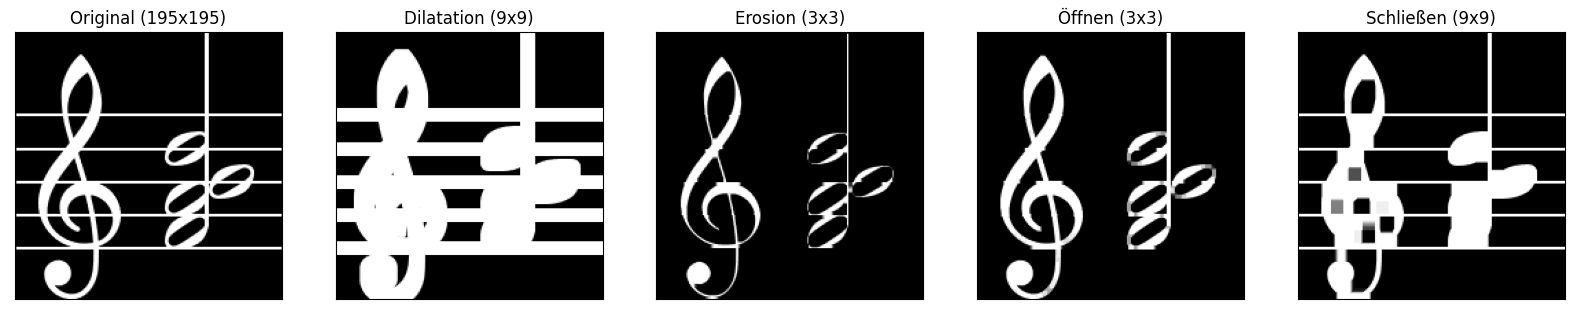

In [94]:
idx = 2
sample_idx = f"{idx:03d}"

orig_img_x = cv2.imread(os.path.join(PNG_PATH, f"{sample_idx}", "out-0.png"))
bboxes = load_bboxes(BBOX_PATH, sample_idx, img_shape=orig_img_x.shape)
systems = [bbox for bbox in bboxes if bbox["type"]=="ClefG"]
# systems = {bbox["id"]: bbox for bbox in bboxes if bbox["type"]=="System"}
print(len(systems))

# grab system
sys_idx = 0
eps = 15
system = systems[sys_idx]
x0 = system["x"] - eps
x1 = x0 + system["width"] + eps + eps
y0 = system["y"] - eps
y1 = y0 + system["height"] + eps + eps

# x1 += 43
sample = 255 - orig_img_x[y0:y1, x0:x1]
# sample[560:, 870:920] = 0

sample = 255 - cv2.imread("plots/morph_base.png")
sample[:, -1] = 0
sample[:, 0] = 0

# apply morph ops
results = [sample]
titles = [f"Original ({sample.shape[0]}x{sample.shape[1]})"]

# dilation
kernel_size = (9, 9)
kernel = np.ones(kernel_size, np.uint8)
res = cv2.dilate(sample, kernel)
results.append(res)
titles.append(f"Dilatation ({kernel_size[0]}x{kernel_size[1]})")

# erosion
kernel_size = (3, 3)
kernel = np.ones(kernel_size, np.uint8)
res = cv2.erode(sample, kernel)
results.append(res)
titles.append(f"Erosion ({kernel_size[0]}x{kernel_size[1]})")

# opening
kernel_size = (3, 3)
kernel = np.ones(kernel_size, np.uint8)
res = cv2.morphologyEx(sample, cv2.MORPH_OPEN, kernel)
results.append(res)
titles.append(f"Öffnen ({kernel_size[0]}x{kernel_size[1]})")

# closing
kernel_size = (9, 9)
kernel = np.ones(kernel_size, np.uint8)
res = cv2.morphologyEx(sample, cv2.MORPH_CLOSE, kernel)
results.append(res)
titles.append(f"Schließen ({kernel_size[0]}x{kernel_size[1]})")

fig, axs = plt.subplots(1, len(results), figsize=(20, 20))
# fig, axs = plt.subplots(len(results), 1, figsize=(20, 20))
for idx, res in enumerate(results):
    vis = res
    # vis = 255 - vis
    axs[idx].imshow(vis)
    axs[idx].get_xaxis().set_visible(False)
    axs[idx].get_yaxis().set_visible(False)
    axs[idx].set_title(titles[idx])
    cv2.imwrite(os.path.join("plots", f"{titles[idx]}.png"), vis)
os.path.join(PNG_PATH, f"{sample_idx}", "out-0.png")

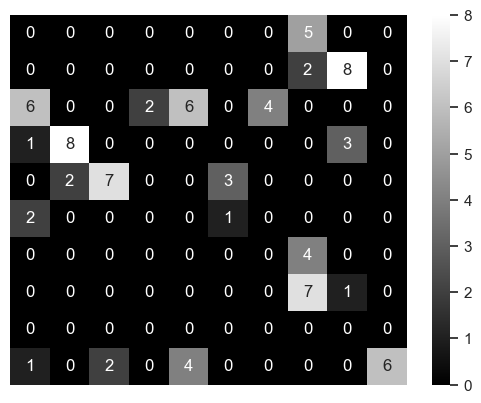

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

results = np.random.randint(0, 9, size=(10, 10))
results *= np.random.randint(0, 2, size=(10, 10))
results *= np.random.randint(0, 2, size=(10, 10))
labels = np.array([f"{value:d}" for value in results.flatten()]).reshape(10, 10)

fig, ax = plt.subplots()
tmp = sns.heatmap(results, annot=labels, fmt="", cmap='gray', ax=ax)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.savefig('plots/sample_values.png', dpi=400)

array([ 0.        ,  0.03921569,  0.15686275,  0.19607843,  0.23529412,
        0.66666667,  0.74509804,  0.82352941,  0.90196078,  0.94117647,
        1.45098039,  1.56862745,  1.68627451,  1.7254902 ,  1.84313725,
        1.92156863,  1.96078431,  2.47058824,  2.66666667,  2.90196078,
        2.98039216,  3.05882353,  3.09803922,  3.25490196,  4.50980392,
        5.05882353,  5.37254902,  5.88235294,  6.07843137,  6.15686275,
        6.23529412,  6.39215686,  6.98039216,  7.09803922,  7.17647059,
        7.60784314,  7.68627451,  7.76470588,  7.80392157,  7.88235294,
        8.        ,  8.23529412,  8.78431373,  8.82352941,  8.98039216,
        9.21568627,  9.25490196,  9.64705882,  9.80392157,  9.84313725,
        9.88235294,  9.92156863, 10.        ])

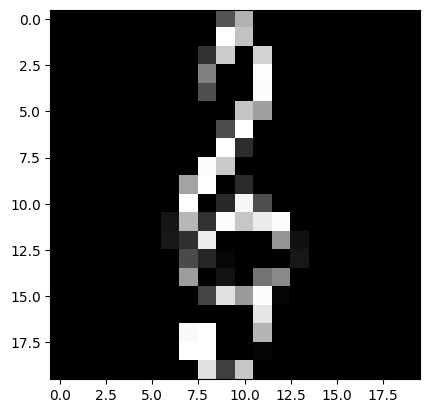

In [28]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

img = 255 - cv2.imread("plots/pixels.png")
img[-1:, :] =  0
img = cv2.resize(img, (20, 20), cv2.INTER_AREA)
# img *= img
plt.imshow(img)
np.unique((img[..., 0] / np.max(img[..., 0])* 10))

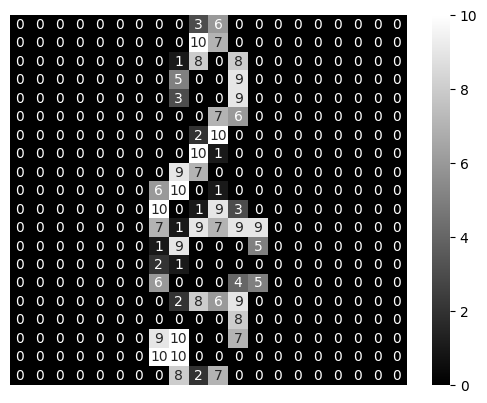

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

results = (img[..., 0] / np.max(img[..., 0])* 10)
results = results.astype(np.uint8)
labels = np.array([f"{value:d}" for value in results.flatten()]).reshape(results.shape)

fig, ax = plt.subplots()
tmp = sns.heatmap(results, annot=labels, fmt="", cmap='gray', ax=ax)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.savefig('plots/sample_values.png', dpi=400)

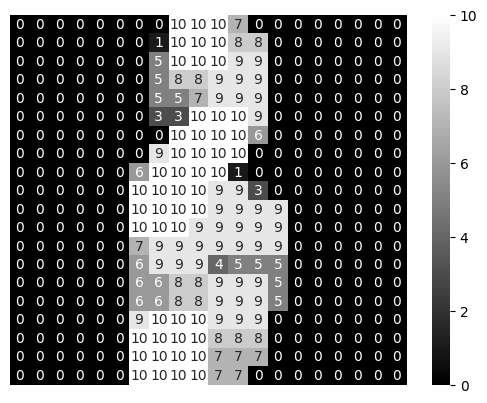

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

kernel = np.ones((3, 3), np.uint8)
results = cv2.dilate(results, kernel)
labels = np.array([f"{value:d}" for value in results.flatten()]).reshape(results.shape)

fig, ax = plt.subplots()
tmp = sns.heatmap(results, annot=labels, fmt="", cmap='gray', ax=ax)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.savefig('plots/sample_values_dil.png', dpi=400)

# DBSCAN

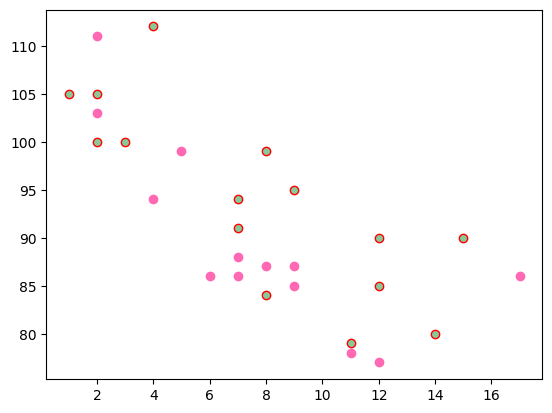

In [4]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array([5,7,8,7,2,17,2,9,4,11,12,9,6])
y = np.array([99,86,87,88,111,86,103,87,94,78,77,85,86])
plt.scatter(x, y, color = 'hotpink')

x = np.array([2,2,8,1,15,8,12,9,7,3,11,4,7,14,12])
y = np.array([100,105,84,105,90,99,90,95,94,100,79,112,91,80,85])
plt.scatter(x, y, color = '#88c999', linewidths=1, edgecolors='#f00')


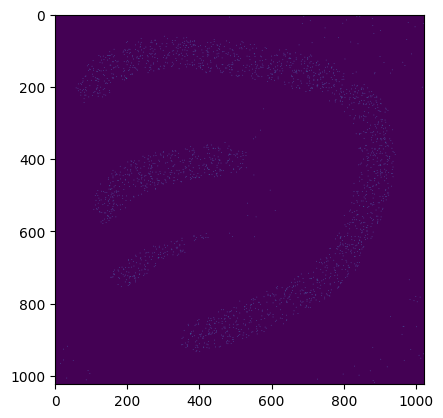

In [91]:
import cv2
seed = cv2.imread("plots/seed.png", cv2.IMREAD_GRAYSCALE)

res = np.zeros_like(seed)
for y, x in np.argwhere(seed > 0):
    if np.random.random() * seed[x, y] * 0.5 > 125:
        if np.random.random() > 0.5:
            res[x, y] = 255
for y, x in np.argwhere(seed == 0):
    if np.random.random() > 0.9995:
        res[x, y] = 255

plt.imshow(res)

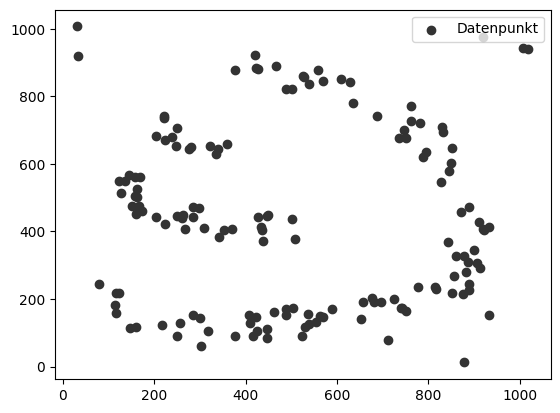

In [143]:
points = np.argwhere(res > 0)
np.random.shuffle(points)
points = points[:150]
ys, xs = points[:, 0], points[:, 1]
sc = plt.scatter(xs, ys, color='#333')
plt.legend([sc], ["Datenpunkt"], loc='upper right')
# plt.axis('off')


In [144]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=100, min_samples=4).fit(points)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 6


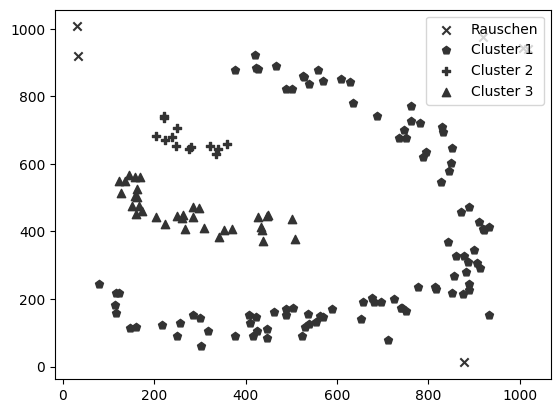

In [145]:
unique_labels = np.unique(labels)

markers = {'.': 'point', ',': 'pixel', 'o': 'circle', 'v': 'triangle_down', '^': 'triangle_up', '<': 'triangle_left', '>': 'triangle_right', '1': 'tri_down', '2': 'tri_up', '3': 'tri_left', '4': 'tri_right', '8': 'octagon', 's': 'square', 'p': 'pentagon', '*': 'star', 'h': 'hexagon1', 'H': 'hexagon2', '+': 'plus', 'x': 'x', 'D': 'diamond', 'd': 'thin_diamond', '|': 'vline', '_': 'hline', 'P': 'plus_filled', 'X': 'x_filled', 0: 'tickleft', 1: 'tickright', 2: 'tickup', 3: 'tickdown', 4: 'caretleft', 5: 'caretright', 6: 'caretup', 7: 'caretdown', 8: 'caretleftbase', 9: 'caretrightbase', 10: 'caretupbase', 11: 'caretdownbase', 'None': 'nothing', 'none': 'nothing', ' ': 'nothing', '': 'nothing'}
ms = ['p', 'P',  '^', 's']
scatters = []

for label in unique_labels:
    if label == -1:
        sc = plt.scatter(points[labels == label][:, 1],points[labels == label][:, 0], color="#333", marker='x')
    else:
        sc = plt.scatter(points[labels == label][:, 1],points[labels == label][:, 0], color="#333", marker=ms[label])
    scatters.append(sc)
# plt.scatter(xs, ys, edgecolors='#333', linewidths=1, color='none')
plt.legend(scatters, ('Rauschen', 'Cluster 1', 'Cluster 2',  'Cluster 3', 'Cluster 4'), loc='upper right',)
# plt.axis('off')

# Gaussian Mixture Models

Text(0.5, 0, 'Häfung')

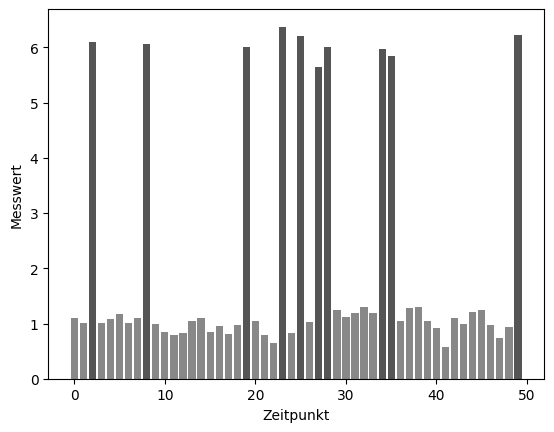

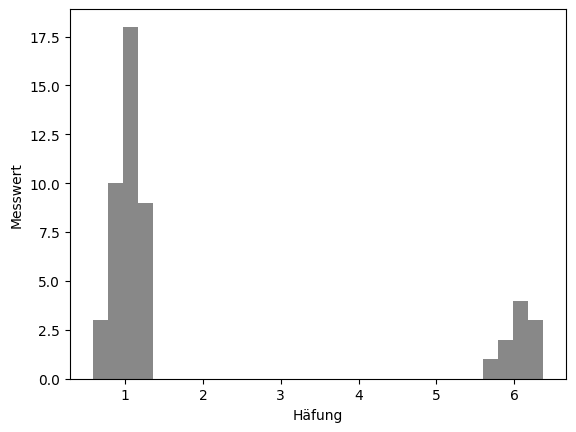

In [101]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.mixture import GaussianMixture

# Generiere Daten
a = 0.
b = 5.
data = np.concatenate((np.repeat(a, 40), np.repeat(b, 10)))

# Vermische sie und füge Rauschen hinzu
np.random.shuffle(data)
noise = np.random.normal(1, .2, len(data))
data += noise

# Wende GMM an
gmm = GaussianMixture(n_components=2, tol=1e-9, max_iter=0).fit(data[:, None])
gmm_labels = gmm.predict(data[:, None])

# Stelle Ergebnis dar
plt.bar(np.arange(0, data.shape[0]), data, color='#555')
plt.bar(np.arange(0, data.shape[0]), data * (1 - gmm_labels), color="#888")
plt.xlabel("Zeitpunkt")
plt.ylabel("Messwert")

plt.figure()
plt.hist(data, bins=30, color='#888')
plt.ylabel("Messwert")
plt.xlabel("Häfung")


DynamicP
1402 2139 1914 2651


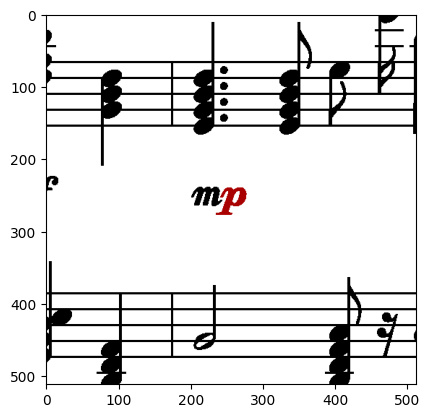

In [258]:
import os
import random
import cv2
import numpy as np
from utils.dataset import load_mask, load_bboxes, load_classIdxMap, load_stafflines
import matplotlib.pyplot as plt
import json
from PIL import ImageColor

DATASET_PATH = os.path.join("..", "..", "datasets", "generated")
PNG_PATH = os.path.join(DATASET_PATH, "png")
BBOX_PATH = os.path.join(DATASET_PATH, "bbox")
OUT_DIR = os.path.join(DATASET_PATH, "aug")
AUG_PATH = os.path.join(DATASET_PATH, "aug")

with open(os.path.join(DATASET_PATH, "classlist.json")) as file:
    classlist = json.load(file)
    classmap = {c["id"]:c["class"] for c in classlist}
    classmap_inv = {c["class"]:c["id"] for c in classlist}

idx = 3
sample_idx = f"{idx:03d}"
aug = "ideal"

# for each sample:
orig_img_x = cv2.imread(os.path.join(AUG_PATH, aug, "x", f"{sample_idx}.png"))
orig_img_y = cv2.imread(os.path.join(AUG_PATH, aug, "y", f"{sample_idx}.png"), cv2.IMREAD_GRAYSCALE)

bboxes = load_bboxes(BBOX_PATH, sample_idx, img_shape=orig_img_x.shape)
systems = {bbox["id"]: bbox for bbox in bboxes if bbox["type"]=="System"}
unique_types = list(set([bbox["type"] for bbox in bboxes if bbox["type"] != "System"]))

# get all bboxes of current type
type = unique_types[41]
tbs = [bbox for bbox in bboxes if bbox["type"] == type]
print(type)

# pick random bbox
rand_idx = random.randint(0, len(tbs) - 1)
bbox = tbs[rand_idx]
cx = bbox["cx"]
cy = bbox["cy"]
w = bbox["width"]
h = bbox["height"]

# get frame centered around bbox center
hsize = 256
x0 = cx - hsize
x1 = cx + hsize
y0 = cy - hsize
y1 = cy + hsize
print(x0, y0, x1, y1)
if (x0 < 0):
    x1 -= x0
    x0 = 0
if (y0 < 0):
    y1 -= y0
    y0 = 0

vis = 255 - orig_img_x
vis[orig_img_y==classmap_inv[type]] = ImageColor.getcolor("#a90000", 'RGB')
vis = vis[y0:y1, x0:x1]

plt.imshow(vis)
# plt.imshow(img_y==8)
os.makedirs("plots/samples", exist_ok=True)


In [225]:
cv2.imwrite(f"plots/samples/{classmap_inv[type]}_{type}.png", cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))

True

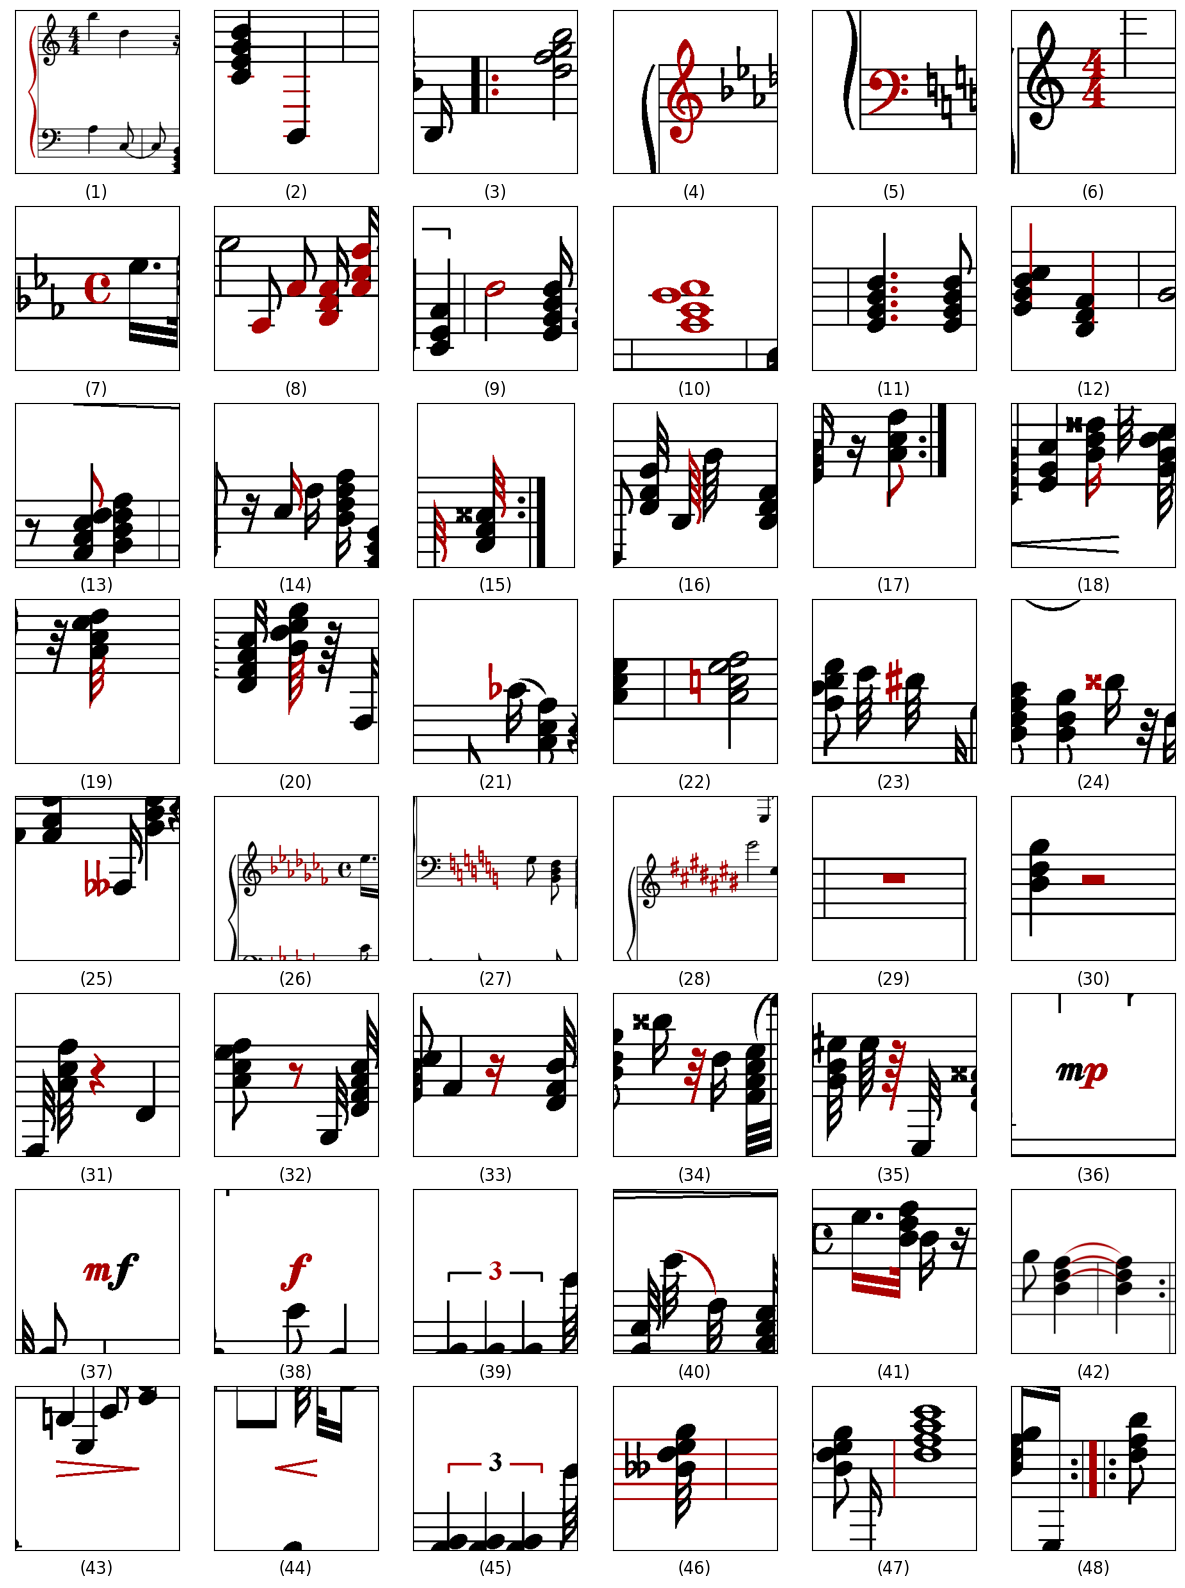

In [262]:
fig, axs = plt.subplots(8, 6, figsize=(15, 20))
axs = axs.reshape(-1)

files = os.listdir("plots/samples")
files = sorted(files, key=lambda x: int(x.split("_")[0]))

for idx, file in enumerate(files):
    img = cv2.imread(f"plots/samples/{file}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    basename = file.split(".")[0]
    name = basename.split("_")[1]
    num = basename.split("_")[0]
    axs[idx].imshow(img)
    axs[idx].axes.get_xaxis().set_visible(False)
    axs[idx].axes.get_yaxis().set_visible(False)
    axs[idx].set_title(f"({num})", y=-0.2, fontsize=12)
    # axs[idx].set_title(f"{name}", y=-0.2, fontsize=12)

In [240]:
{'Brace': 'Akkolade',
 'LedgerLine': 'Hilfslinie',
 'RepeatDot': 'Wiederholungspunkt',
 'ClefG': '',
 'ClefF': '',
 'TimeSig4': '',
 'TimeSigCommon': '',
 'NoteheadBlack': '',
 'NoteheadHalf': '',
  'NoteheadWhole': '',
  'AugmentationDot': '',
  'Stem': '',
  'Flag8thUp': '',
  'Flag16thUp': '',
  'Flag32ndUp': '',
  'Flag64thUp': '',
  'Flag8thDown': '',
  'Flag16thDown': '',
  'Flag32ndDown': '',
  'Flag64thDown': '',
  'AccidentalFlat': '',
  'AccidentalNatural': '',
  'AccidentalSharp': '',
  'AccidentalDoubleSharp': '',
  'AccidentalDoubleFlat': '',
  'KeyFlat': '',
  'KeyNatural': '',
  'KeySharp': '',
  'RestWhole': '',
  'RestHalf': '',
  'RestQuarter': '',
  'Rest8th': '',
  'Rest16th': '',
  'Rest32nd': '',
  'Rest64th': '',
  'DynamicP': '',
  'DynamicM': '',
  'DynamicF': '',
  'Tuplet3': '',
  'Slur': '',
  'Beam': '',
  'Tie': '',
  'DynamicCrescendoHairpin': '',
  'DynamicDiminuendoHairpin': '',
  'TupletBracket': '',
  'Staff': '',
  'BarLine': '',
  'BarLineThick': ''
  }

{1: 'Brace',
 2: 'LedgerLine',
 3: 'RepeatDot',
 4: 'ClefG',
 5: 'ClefF',
 6: 'TimeSig4',
 7: 'TimeSigCommon',
 8: 'NoteheadBlack',
 9: 'NoteheadHalf',
 10: 'NoteheadWhole',
 11: 'AugmentationDot',
 12: 'Stem',
 13: 'Flag8thUp',
 14: 'Flag16thUp',
 15: 'Flag32ndUp',
 16: 'Flag64thUp',
 17: 'Flag8thDown',
 18: 'Flag16thDown',
 19: 'Flag32ndDown',
 20: 'Flag64thDown',
 21: 'AccidentalFlat',
 22: 'AccidentalNatural',
 23: 'AccidentalSharp',
 24: 'AccidentalDoubleSharp',
 25: 'AccidentalDoubleFlat',
 26: 'KeyFlat',
 27: 'KeyNatural',
 28: 'KeySharp',
 29: 'RestWhole',
 30: 'RestHalf',
 31: 'RestQuarter',
 32: 'Rest8th',
 33: 'Rest16th',
 34: 'Rest32nd',
 35: 'Rest64th',
 36: 'DynamicP',
 37: 'DynamicM',
 38: 'DynamicF',
 39: 'Tuplet3',
 40: 'Slur',
 41: 'Beam',
 42: 'Tie',
 43: 'DynamicCrescendoHairpin',
 44: 'DynamicDiminuendoHairpin',
 45: 'TupletBracket',
 46: 'Staff',
 47: 'BarLine',
 48: 'BarLineThick'}

# Show Augmentations

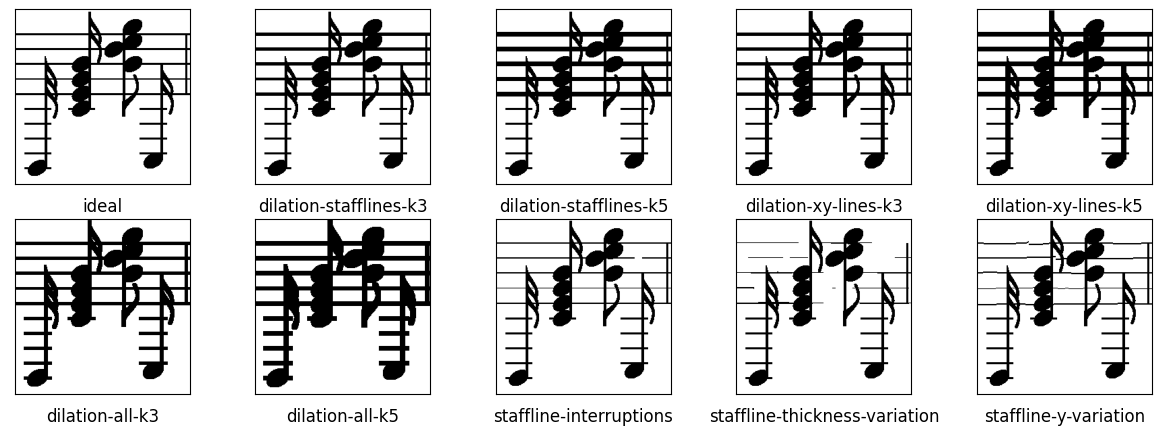

In [15]:
import os
import random
import cv2
import numpy as np
from utils.dataset import load_mask, load_bboxes, load_classIdxMap, load_stafflines
import matplotlib.pyplot as plt
import json
from PIL import ImageColor

DATASET_PATH = os.path.join("..", "..", "datasets", "generated")
PNG_PATH = os.path.join(DATASET_PATH, "png")
BBOX_PATH = os.path.join(DATASET_PATH, "bbox")
OUT_DIR = os.path.join(DATASET_PATH, "aug")
AUG_PATH = os.path.join(DATASET_PATH, "aug")

with open(os.path.join(DATASET_PATH, "classlist.json")) as file:
    classlist = json.load(file)
    classmap = {c["id"]:c["class"] for c in classlist}
    classmap_inv = {c["class"]:c["id"] for c in classlist}

idx = 3
sample_idx = f"{idx:03d}"
augmentations = [
    'ideal',
    'dilation_stafflines_k3',
    'dilation_stafflines_k5',
    'dilation_xy_lines_k3',
    'dilation_xy_lines_k5',
    'dilation_all_k3',
    'dilation_all_k5',
    'staffline_interruptions',
    'staffline_thickness_variation',
    'staffline_y_variation',
]

fig, axs = plt.subplots(2, 5, figsize=(15, 5))
axs = axs.reshape(-1)

x0 = 719
y0 = 512
x1 = x0 + 260
y1 = y0 + 260

for idx, aug in enumerate(augmentations):
    
    # for each sample:
    orig_img_x = 255 - cv2.imread(os.path.join(AUG_PATH, aug, "x", f"{sample_idx}.png"))[y0:y1, x0:x1]
    orig_img_y = cv2.imread(os.path.join(AUG_PATH, aug, "y", f"{sample_idx}.png"), cv2.IMREAD_GRAYSCALE)[y0:y1, x0:x1]
    
    axs[idx].imshow(orig_img_x)
    axs[idx].axes.get_xaxis().set_visible(False)
    axs[idx].axes.get_yaxis().set_visible(False)
    axs[idx].set_title(f"{aug.replace('_', '-')}", y=-0.2, fontsize=12)


['dilation_all_k3',
 'dilation_all_k5',
 'dilation_stafflines_k3',
 'dilation_stafflines_k5',
 'dilation_xy_lines_k3',
 'dilation_xy_lines_k5',
 'ideal',
 'staffline_interruptions',
 'staffline_thickness_variation',
 'staffline_y_variation']